In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model

In [2]:
input_shape = (128, 128, 3)
data_dir = './dfdc_data/train_sample_videos/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
# Y = np.array(Y) # for testing
Y = to_categorical(Y, 2) # for training

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
# model.load_weights('deepfake-detection-model.h5')
# model

In [4]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 30
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/30
30/30 [==============================] - 537s 17s/step - loss: 0.7593 - accuracy: 0.4582 - val_loss: 0.9148 - val_accuracy: 0.3605
Epoch 2/30
30/30 [==============================] - 495s 17s/step - loss: 0.6285 - accuracy: 0.7050 - val_loss: 0.8631 - val_accuracy: 0.3431
Epoch 3/30
30/30 [==============================] - 489s 16s/step - loss: 0.5203 - accuracy: 0.8363 - val_loss: 0.8377 - val_accuracy: 0.3658
Epoch 4/30
30/30 [==============================] - 492s 16s/step - loss: 0.4408 - accuracy: 0.8883 - val_loss: 0.7922 - val_accuracy: 0.4166
Epoch 5/30
30/30 [==============================] - 493s 16s/step - loss: 0.3525 - accuracy: 0.9081 - val_loss: 0.7671 - val_accuracy: 0.4566
Epoch 6/30
30/30 [==============================] - 498s 17s/step - loss: 0.2774 - accuracy: 0.9411 - val_loss: 0.7255 - val_accuracy: 0.5554
Epoch 7/30
30/30 [==============================] - 499s 17s/step - loss: 0.2211 - accuracy: 0.9477 - val_loss: 0.6621 - val_accuracy: 0.6529
Epoch 

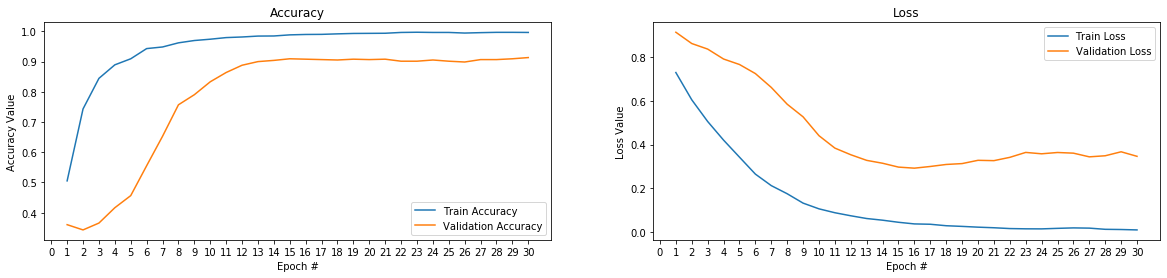

In [8]:
epoch_list = list(range(1,EPOCHS+1))

# fig = plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

# t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
# f.subplots_adjust(top=0.85, wspace=0.3)

# ax1 = fig.add_subplot(2,1,1)
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

# ax2 = fig.add_subplot(2,1,2)
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
ax2.legend(loc="best")

# Save just the portion _inside_ the second axis's boundaries
extent2 = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('incp_loss_plot.png', bbox_inches=extent2.expanded(1.2, 1.4), dpi = 300)

extent1 = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('incp_accuracy_plot.png', bbox_inches=extent1.expanded(1.2, 1.4), dpi = 300)

# Pad the saved area by 10% in the x-direction and 20% in the y-direction
# fig.savefig('ax2_figure_expanded.png', bbox_inches=extent.expanded(1.1, 1.2))

In [ ]:
print(Y_val.shape)
print(X_val.shape)

In [ ]:
Y_val

In [ ]:
X_val

In [ ]:
Y_val_pred_proba =  model.predict_proba(X_val)
print(Y_val_pred_proba.shape)
Y_val_pred_proba

# Y_val_pred_proba[:,1] > 0.5 
# tells whether the sample has class 1 or not, False : 0 class , True : 1 class

In [ ]:
Y_val_pred = model.predict_classes(X_val)
Y_val_pred

In [ ]:
Y_val

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val, Y_val_pred)

In [ ]:
# print("ROC AUC Score:", metrics.roc_auc_score(Y_val, Y_val_pred_proba)) -> better use auc on roc_curve
# print("AP Score:", metrics.average_precision_score(Y_val, Y_val_pred_proba))
print("\n")
print(metrics.classification_report(Y_val, Y_val_pred))

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(Y_val, Y_val_pred)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Inception-Resnet-v2 AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("incp_roc_plot.png", dpi = 150)

plt.show()

In [ ]:
model.save('deepfake-detection-model.h5')

In [ ]:
model = load_model('deepfake-detection-model.h5')
model.load_weights('deepfake-detection-model.h5')
model